# Dialog skill analysis for Watson Assistant

## Introduction
Dialog Skill Analysis for Watson Assistant (WA) is intended for use by chatbot designers, developers and data scientists who would like to experiment with and improve their existing dialog skill design.  

This notebook assumes familiarity with the Watson Assistant product as well as concepts involved in dialog skill design such as intent, entities, and utterances.   

### Environment
- Python version 3.6 or above is required. 
- Install dependencies with `pip install -r requirements.txt` and refer to `requirements.txt`

### Link to the source repository

<a href="https://github.com/watson-developer-cloud/assistant-dialog-skill-analysis" target="_blank" rel="noopener no referrer">watson-developer-cloud/assistant-dialog-skill-analysis</a>

Install all the required packages and filter out any warnings.

In [1]:
from IPython.display import Markdown, display, HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install --index-url https://pypi.python.org/simple  -U "pip"
!pip install --index-url https://pypi.python.org/simple  -U "assistant-dialog-skill-analysis>=1.0.1"

In [3]:
# Standard python libraries
import sys, os
import json
import importlib
from collections import Counter

# External python libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import ibm_watson

# Internal python libraries
from assistant_dialog_skill_analysis.utils import skills_util
from assistant_dialog_skill_analysis.highlighting import highlighter
from assistant_dialog_skill_analysis.data_analysis import summary_generator
from assistant_dialog_skill_analysis.data_analysis import divergence_analyzer
from assistant_dialog_skill_analysis.data_analysis import similarity_analyzer
from assistant_dialog_skill_analysis.term_analysis import chi2_analyzer
from assistant_dialog_skill_analysis.term_analysis import keyword_analyzer
from assistant_dialog_skill_analysis.term_analysis import entity_analyzer
from assistant_dialog_skill_analysis.confidence_analysis import confidence_analyzer
from assistant_dialog_skill_analysis.inferencing import inferencer
from assistant_dialog_skill_analysis.experimentation import data_manipulator

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Table of contents

1. [Part 1: Prepare the training data](#part1)<br>
2. [Part 2: Prepare the test data](#part2)<br>
3. [Part 3: Perform advanced analysis](#part3)<br>
4. [Part 4: Summary](#part4)<br>

<a id='part1'></a>
# Part 1: Prepare the training data
1.1 [Set up access to the training data](#part1)<br>
1.2 [Process Dialog Skill Training Data](#part1.2)<br>
1.3 [Analyze data distribution](#part1.3)<br>
1.4 [Perform a correlation analysis](#part1.4)<br>
1.5 [Visualize terms using a heat map](#part1.5)<br>
1.6 [Ambiguity in the training data](#part1.6)<br>

<a id='setup'></a>
## 1.1 Set up access to the training data

Provide access credentials for an existing dialog skill that you would like to analyze. For this you need your API Key and Workspace ID values.

In [4]:
importlib.reload(skills_util)

# Change Assistant API version if needed
# Find Latest --> https://cloud.ibm.com/docs/services/assistant?topic=assistant-release-notes
API_VERSION = '2019-02-28'

# Change URL based on IBM Cloud datacenter you use   
URL = "https://gateway.watsonplatform.net/assistant/api" # Dallas (Default US South)

#URL = "https://gateway-s.watsonplatform.net/assistant/api" # Dallas Staging
#URL = "https://gateway-wdc.watsonplatform.net/assistant/api" # Washington, DC
#URL = "https://gateway-fra.watsonplatform.net/assistant/api" # Frankfurt
#URL = "https://gateway-syd.watsonplatform.net/assistant/api" # Sydney
#URL = "https://gateway-tok.watsonplatform.net/assistant/api" # Tokyo
#URL = "https://gateway-lon.watsonplatform.net/assistant/api" # London

# By default we only need the IAM API Key & the Workspace ID

# If you run the notebook regularly you can uncomment the two lines below
# & comment out the line after it
#iam_apikey = '###'
#workspace_id = '###'
#Prompt user for credentials
iam_apikey, workspace_id = skills_util.input_credentials()

conversation, workspace = skills_util.retrieve_workspace(iam_apikey=iam_apikey,
                                                         workspace_id=workspace_id,
                                                         url=URL,
                                                         api_version=API_VERSION)

#If you do not have IAM based API Keys
#but have access to a Username, Password & Workspace ID
#You can comment out the two lines above & uncomment the lines below to authenticate
#username = 'apikey'
#password = '###'
#workspace_id = '###'
#conversation, workspace = skills_util.retrieve_workspace(username=username,
#                                                         password=password,
#                                                         workspace_id=workspace_id,
#                                                         url=URL,
#                                                         api_version=API_VERSION)

Please enter apikey: ········
Please enter workspace-id: ········


In [5]:
# Extract user workspace
workspace_data, workspace_vocabulary = skills_util.extract_workspace_data(workspace)
entity_dict = conversation.list_entities(workspace_id).get_result()
entities_list = [item['entity'] for item in entity_dict['entities']]
# Create workspace data frame
workspace_pd = pd.DataFrame(workspace_data)

display(Markdown("### Sample of Utterances & Intents"))
display(HTML(workspace_pd.sample(n = len(workspace_pd) if len(workspace_pd)<10 else 10)
             .to_html(index=False)))
if entities_list:
    display(Markdown("### Sample of Entities"))
    display(HTML(pd.DataFrame({"Entity":entities_list})
                 .sample(n = len(entities_list) if len(entities_list)<10 else 10)
                 .to_html(index=False)))

### Sample of Utterances & Intents

utterance,intent
can you assist me,Help
talk to a human,General_Connect_to_Agent
Please assist me to get to an agent,General_Connect_to_Agent
Contact person,General_Connect_to_Agent
Pls connect,General_Connect_to_Agent
Hey how are you doing,General_Greetings
Hi there,General_Greetings
Can I talk to someone?,General_Connect_to_Agent
can you help,Help
Hello I am looking for some help here,General_Greetings


### Sample of Entities

Entity
specialist
phone
sys-number
zip_code
landmark
sys-time
holiday
sys-date
reply


<a id='part1.2'></a>
## 1.2 Process the dialog skill training data

Generate summary statistics related to the given skill and workspace.

In [6]:
importlib.reload(summary_generator)
summary_generator.generate_summary_statistics(workspace_data, entities_list)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,182
2,Unique Intents,9
3,Average User Examples per Intent,20
4,Standard Deviation from Average,15
5,Total Number of Entities,9


<a id='part1.3'></a>
## 1.3 Analyze the data distribution

- [Analyze class imbalance](#imbalance)
- [List the distribution of user examples by intent](#distribution)
- [Actions for class imbalance](#actionimbalance)

### Analyze class imbalance<a id='imbalance'></a>

Analyze whether the data set contains class imbalance by checking whether the largest intent contains less than double the number of user examples contained in the smallest intent. If there is an imbalance it does not necessarily indicate an issue; but you should review the [actions](#actionimbalance) section below.

In [7]:
importlib.reload(summary_generator)
class_imb_flag = summary_generator.class_imbalance_analysis(workspace_pd)

### <font style='color:rgb(165, 34, 34);'> Class Imbalance Detected         </font>

- Data could be potentially biased towards intents with more user         examples

- E.g. Intent < General_Connect_to_Agent > has < 47 > user examples while intent < Goodbye > has         just < 5 > user examples 

### List the distribution of user examples by intent<a id='distribution'></a>
Display the distribution of intents versus the number of examples per intent (sorted by the number of examples per intent) below. Ideally you should not have large variations in terms of number of user examples for various intents. 

## <p style="text-align: center;">Sorted Distribution of User Examples                      per Intent</p>

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


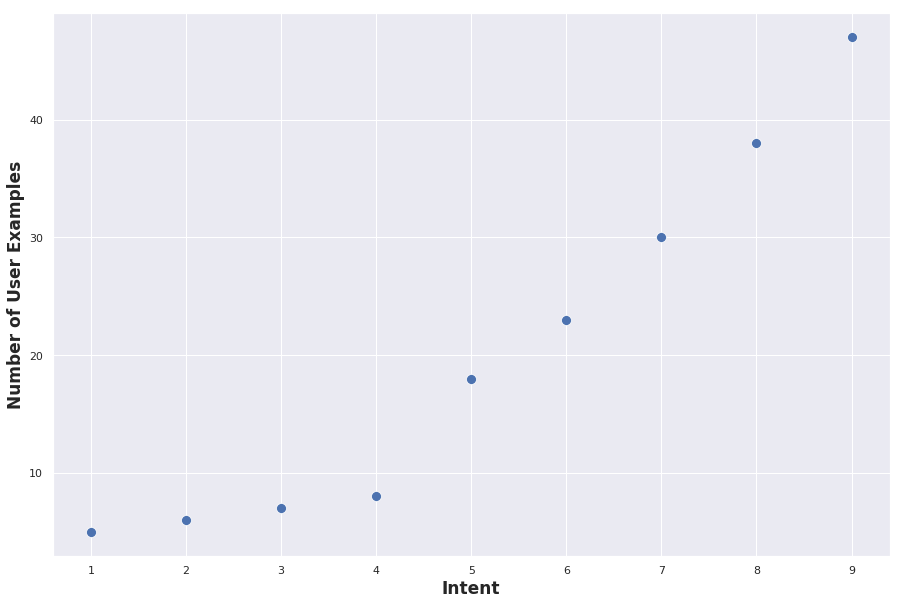

In [8]:
importlib.reload(summary_generator)
summary_generator.scatter_plot_intent_dist(workspace_pd)

In [9]:
importlib.reload(summary_generator)
summary_generator.show_user_examples_per_intent(workspace_data)

### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,Goodbye,5
2,Help,6
3,Cancel,7
4,Thanks,8
5,Customer_Care_Appointments,18
6,Customer_Care_Store_Location,23
7,General_Greetings,30
8,Customer_Care_Store_Hours,38
9,General_Connect_to_Agent,47


### Actions for class imbalance<a id='actionimbalance'></a>

Class imbalance will not always lead to lower accuracy, which means that all intents (classes) do not need to have the same number of examples:

- For intents like `updateBankAccount` and `addNewAccountHolder` where the semantics difference between them is subtler, the number of examples per intent needs to be somewhat balanced otherwise the classifier might favor the intent with the higher number of examples.
- For intents like `greetings` that are semantically distinct from other intents like `updateBankAccount`, it may be acceptable for it to have fewer examples per intent and still be easy for the intent detector to classify.

If the intent classification accuracy is lower than expected during testing, you should re-examine the distribution analysis.  

With regard to sorted distribution of examples per intent, if the sorted number of user examples varies a lot across different intents, it can be a potential source of bias for intent detection. Large imbalances in general should be avoided. This can potentially lead to lower accuracy. If your graph displays this characteristic, this could be a source of error.

For further guidance on adding more examples to help balance out your distribution, refer to 
<a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intent-recommendations#intent-recommendations-get-example-recommendations" target="_blank" rel="noopener no referrer">Intent Example Recommendation</a>.

<a id='part1.4'></a>
## 1.4  Perform correlation analysis

- [Retrieve the most correlated unigrams and bigrams for each intent](#retrieve)
- [Actions for anomalous correlations](#anomalous)

### Retrieve the most correlated unigrams and bigrams for each intent<a id='retrieve'></a>

Perform a chi square significance test using count features to determine the terms that are most correlated with each intent in the data set. 

A `unigram` is a single word, while a `bigram` is two consecutive words from within the training data. For example, if you have a sentence like `Thank you for your service`, each of the words in the sentence are considered unigrams while terms like `Thank you`, `your service` are considered bigrams.

Terms such as `hi`, `hello` correlated with a `greeting` intent are reasonable. But terms such as `table`, `chair` correlated with the `greeting` intent are anomalous. A scan of the most correlated unigrams & bigrams for each intent can help you spot potential anomalies within your training data.

**Note**: We ignore the following common words from consideration `an, a, in, on, be, or, of, a, and, can, is, to, the, i`

In [10]:
importlib.reload(chi2_analyzer)
unigram_intent_dict, bigram_intent_dict = chi2_analyzer.get_chi2_analysis(workspace_pd)

## Chi-squared Analysis

,Intent,Correlated Unigrams,Correlated Bigrams
1,General_Connect_to_Agent,"want, please, talk, speak, agent","are you, connect me, speak human, want speak, want talk"
2,Customer_Care_Store_Hours,"hours, time, what, are, open","time do, do you, what time, what are, you open"
3,General_Greetings,"been, going, hello, good, hey","hey how, have you, hey there, you been, how are"
4,Customer_Care_Store_Location,"give, directions, location, find, where","do get, me directions, get your, where are, how do"
5,Customer_Care_Appointments,"next, visit, meet, make, appointment","appointment for, available tuesday, would like, like make, make appointment"
6,Thanks,"many, appreciated, much, thank, thanks","many thanks, appreciate it, much appreciated, you very, thank you"
7,Cancel,"never, forget, changed, cancel, mind","forget it, changed my, cancel that, cancel request, my mind"
8,Help,"me, assist, assistance, decide, help","you assist, me decide, need assistance, you help, help me"
9,Goodbye,"long, see, ciao, ya, bye","good bye, see ya, so long"


### Actions for anomalous correlations<a id='anomalous'></a>

If you identify unusual or anomalous correlated terms such as: numbers, names and so on, which should not be correlated with an intent, consider the following:
  
- **Case 1** : If you see names appearing amongst correlated unigrams or bigrams, add more variation of names so no specific names will be correlated  
- **Case 2** : If you see specific numbers like 1234 amongst correlated unigrams or bigrams and these are not helpful to the use case, remove or mask these numbers from the examples
- **Case 3** : If you see terms which should never be correlated to that specific intent, consider adding or removing terms/examples so that domain specific terms are correlated with the correct intent

<a id='part1.5'></a>
## 1.5 Visualize terms using a heat map

- [Display term analysis for a custom intent list](#customintent)
- [Actions for anomalous terms in the heat map](#heatmap)

A heat map of terms is a method to visualize terms or words that frequently occur within each intent. Rows are the terms, and columns are the intents. 

The code below displays the top 30 intents with the highest number of user examples in the analysis. This number can be changed if needed.

## <p style="text-align: center;"> Token Frequency per Intent </p>

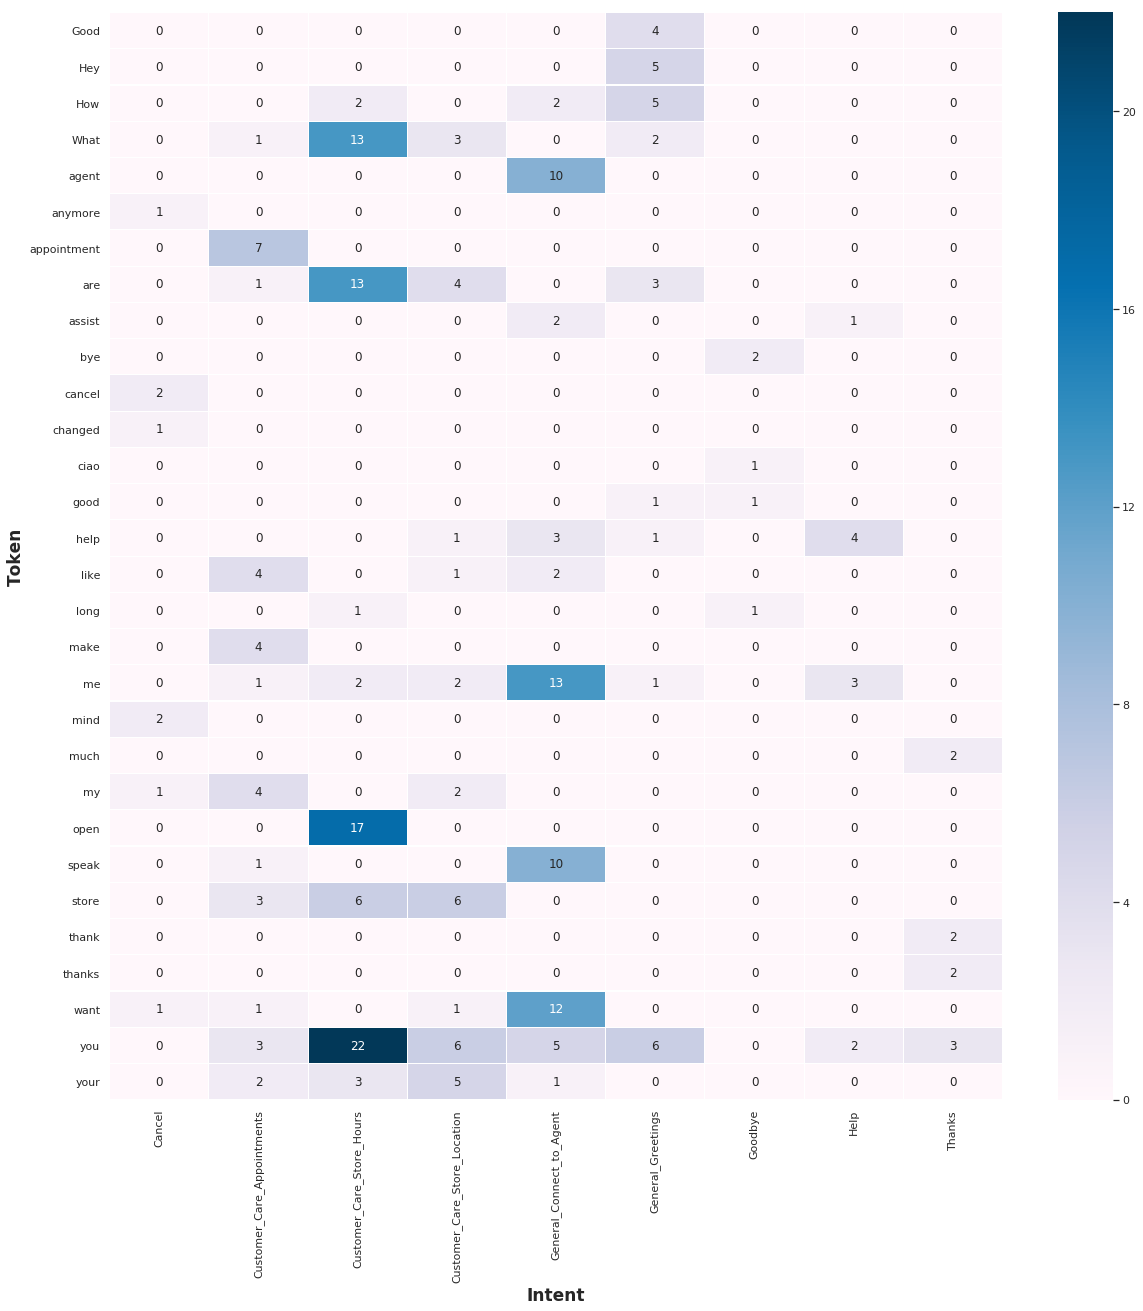

In [11]:
importlib.reload(keyword_analyzer)

INTENTS_TO_DISPLAY = 30  # Total number of intents for display
MAX_TERMS_DISPLAY = 30  # Total number of terms to display

intent_list = []
keyword_analyzer.seaborn_heatmap(workspace_pd, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Display term analysis for a custom intent list<a id='customintent'></a>

If you wish to see term analysis for specific intents, feel free to add those intents to the intent list. This generates a custom term heatmap. The code below displays the top 20 terms, but this can be changed if needed.

In [12]:
importlib.reload(keyword_analyzer)
# intent_list = ['intent1','intent2','intent3'] 
intent_list = [] 


MAX_TERMS_DISPLAY = 20  # Total number of terms to display

if intent_list: 
    keyword_analyzer.seaborn_heatmap(workspace_pd, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Actions for anomalous terms in the heat map<a id='heatmap'></a>

If you notice any terms or words which should not be frequently present within an intent, consider modifying examples in that intent.

<a id='part1.6'></a>
## 1.6 Ambiguity in the training data

- [Uncover ambiguous utterances across intents](#uncover)
- [Actions for ambiguity in the training data](#ambiguityaction)

Run the code blocks below to uncover possibly ambiguous terms based on feature correlation.

Based on the chi-square analysis above, generate intent pairs which have overlapping correlated unigrams and bigrams.
This allows you to get a glimpse of which unigrams or bigrams might cause potential confusion with intent detection:

#### A. Top intent pairs with overlapping correlated unigrams

In [13]:
importlib.reload(chi2_analyzer)
ambiguous_unigram_df = chi2_analyzer.get_confusing_key_terms(unigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

#### B. Top intent pairs with overlapping correlated bigrams

In [14]:
importlib.reload(chi2_analyzer)
ambiguous_bigram_df = chi2_analyzer.get_confusing_key_terms(bigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

#### C. Overlap checker for specific intents

In [15]:
# Add specific intent or intent pairs for which you would like to see overlap
importlib.reload(chi2_analyzer)
intent1 = 'Goodbye'
intent2 = ''
chi2_analyzer.chi2_overlap_check(ambiguous_unigram_df,ambiguous_bigram_df,intent1,intent2)

### Uncover ambiguous utterances across intents<a id='uncover'></a>
The following analysis shows user examples that are similar but fall under different intents.  

In [16]:
importlib.reload(similarity_analyzer)
similar_utterance_diff_intent_pd = similarity_analyzer.ambiguous_examples_analysis(workspace_pd)

### There are no similar utterances within different Intent

### Actions for ambiguity in the training data<a id='ambiguityaction'></a>

**Ambiguous intent pairs**  
If you see terms which are correlated with more than 1 intent, review if this seems anomalous based on the use case for that intent. If it seems reasonable, it is probably not an issue.  

**Ambiguous utterances across intents** 
- **Duplicate utterances**: For duplicate or almost identical utterances, remove those that seem unnecessary.
- **Similar utterances**: For similar utterances, review the use case for those intents and make sure that they are not accidental additions caused by human error when the training data was created.  

For more information about entity, refer to the <a href="https://cloud.ibm.com/docs/services/assistant/services/assistant?topic=assistant-entities" target="_blank" rel="noopener no referrer">Entity Documentation</a>.

For more in-depth analysis related to possible conflicts in your training data across intents, try the conflict detection feature in Watson Assistant. Refer to <br> <a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts" target="_blank" rel="noopener no referrer">Conflict Resolution Documentation</a>.

<a id='part2'></a>
# Part 2: Prepare the test data

Analyze your existing Watson Assistant Dialog Skill with the help of a test set.

2.1. [Obtain test data from Cloud Object Storage](#cos)<br>
2.2. [Evaluate the test data](#evaluate) <br>
2.3. [Analyze the test data](#testanalysis) <br>

## 2.1 Obtain test data from Cloud Object Storage<a id='cos'></a>

Upload a test set in csv format to Cloud Object Storage (COS). Each line in the file should have only `User_Input<comma>Intent`  

For example:
```
hello how are you<comma>Greeting  
I would like to talk to a human<comma>AgentHandoff  
```

For more information about COS, refer to the following link:
<a href="https://cloud.ibm.com/docs/services/cloud-object-storage/libraries?topic=cloud-object-storage-python#python" target="_blank" rel="noopener no referrer">Cloud Object Storage - Using Python</a>.


In [17]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0


COS_AUTH_ENDPOINT ="https://iam.cloud.ibm.com/identity/token"
COS_ENDPOINT = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'
# please fill in the details here:
COS_API_KEY_ID = '###' #API key of your COS
COS_RESOURCE_CRN = '###' #Resource CRN, i.e. 'crn:v1:bluemix:public...''
IBM_COS_BUCKET = '###' #Name of your COS bucket
IBM_COS_FILE_KEY = '###' #Name of the test data, i.e. 'test_data_set.csv'


cos = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

body = cos.Object(IBM_COS_BUCKET, IBM_COS_FILE_KEY).get()['Body']

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
separator = ','
test_df = pd.read_csv(body, sep=separator, names=["utterance", "intent"])
    
display(Markdown("### Random Test Sample"))
display(HTML(test_df.sample(n=10).to_html(index=False)))  

### Random Test Sample

utterance,intent
How many engineers does it take to change a li...,SYSTEM_OUT_OF_DOMAIN
Hey twin,General_Greetings
"Are you open on sundays, and if so what are t...",Customer_Care_Store_Hours
see ya,Goodbye
Do not want a robot?,General_Connect_to_Agent
What are the hours of operation?,Customer_Care_Store_Hours
ciao,Goodbye
give me directions,Customer_Care_Store_Location
how early do you open on Saturdays,Customer_Care_Store_Hours
Hello you silly bot,General_Greetings


## 2.2 Evaluate the test data<a id='evaluate'></a>
These steps can take time if you have a large test set.  

**<font color=red>Note</font>**: You will be charged for calls made from this notebook based on your Watson Assistant plan. 

In [18]:
# Maximum of 5 threads for faster inference
THREAD_NUM = 5
full_results = inferencer.inference(conversation,
                                    workspace_id,
                                    test_df,
                                    max_retries=10,
                                    max_thread=THREAD_NUM, 
                                    verbose=False)

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-1
Exiting Thread-2
Exiting Thread-3
Exiting Thread-5
Exiting Thread-4
--- Total time: 8.201696872711182 seconds ---


<a id='part2.1'></a>
## 2.3 Analyze the test data<a id='testanalysis'></a>

- [Display an overview of the test data](#overview)
- [Compare the test data and the training data](#compare)
- [Determine the overall accuracy on the test set](#accuracy)
- [Analyze the errors](#errors)

### Display an overview of the test data<a id='overview'></a>

In [19]:
importlib.reload(summary_generator)
summary_generator.generate_summary_statistics(test_df)
summary_generator.show_user_examples_per_intent(test_df)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,53
2,Unique Intents,10
3,Average User Examples per Intent,5
4,Standard Deviation from Average,3
5,Total Number of Entities,0


### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,Help,2
2,Thanks,2
3,Cancel,3
4,Goodbye,3
5,Customer_Care_Store_Location,5
6,Customer_Care_Appointments,5
7,SYSTEM_OUT_OF_DOMAIN,7
8,General_Greetings,7
9,Customer_Care_Store_Hours,9
10,General_Connect_to_Agent,10


### Compare the test data and the training data<a id='compare'></a>

Ideally the test and training data distributions should be similar. The following metrics can help identify gaps between the test set and the training set:

**1.**  The distribution of user examples per intent for the test data should be comparable to the training data   
**2.**  The average length of user examples for test and training data should be comparable to the training data <br>
**3.**  The vocabulary and phrasing of utterances in the test data should be comparable to the training data

If your test data comprises of examples labelled from your logs, and the training data comprises of examples created by human subject matter experts, there may be discrepancies between what the virtual assistant designers thought the end users would type and the way they actually type in production. Thus, if you find discrepancies in this section, consider changing your design to resemble the way in which end users use your system more closely.

**<font color=red>Note</font>**: You will be charged for calls made from this notebook  based on your WA plan.

In [20]:
importlib.reload(divergence_analyzer)
divergence_analyzer.analyze_train_test_diff(workspace_pd, test_df, full_results)

## Test Data Evaluation

,Intent,% of Train,% of Test,Absolute Difference %,Train Examples,Test Examples,Test Precision %,Test Recall %,Test F1 %
0,General_Connect_to_Agent,25.82,18.87,6.96,47,10,83.33,100,90.91
1,Customer_Care_Store_Hours,20.88,16.98,3.9,38,9,81.82,100,90
2,General_Greetings,16.48,13.21,3.28,30,7,77.78,100,87.5
3,Customer_Care_Store_Location,12.64,9.43,3.2,23,5,71.43,100,83.33
8,Goodbye,2.75,5.66,2.91,5,3,100,66.67,80
6,Cancel,3.85,5.66,1.81,7,3,100,66.67,80
5,Thanks,4.4,3.77,0.62,8,2,100,100,100
7,Help,3.3,3.77,0.48,6,2,66.67,100,80
4,Customer_Care_Appointments,9.89,9.43,0.46,18,5,100,100,100


Distribution Mismatch Color Code

<font color = 'red'>      Red - Severe </font>

<font color = 'blue'>     Blue - Caution </font>

<font color = 'green'>    Green - Good </font>

### Data Distribution Divergence Test vs Train         <font color='blue'>10.0%</font>

**Note** Metric used is Jensen Shannon Distance

### Test Data Example Length

Average length of user examples is comparable

### Vocabulary Size Test vs Train

,Train Vocabulary Size,Test Vocabulary Size,% Test Set Vocabulary not found in Train
1,262,142,14.79


### Determine the overall accuracy on the test set<a id='accuracy'></a>

In [21]:
importlib.reload(inferencer)
results = full_results[['correct_intent', 'top_confidence','top_intent','utterance']]
accuracy = inferencer.calculate_accuracy(results)
display(Markdown("### Accuracy on Test Data: {} %".format(accuracy)))

### Accuracy on Test Data: 83.02 %

### Analyze the errors<a id='errors'></a>

This section gives you an overview of the errors made by the intent classifier on the test set.  

**Note**: `System Out of Domain` labels are assigned to user examples which get classified with confidence scores less than 0.2 as Watson Assistant considers them to be irrelevant.

In [22]:
importlib.reload(inferencer)
wrongs_df = inferencer.calculate_mistakes(results)
display(Markdown("### Intent Detection Mistakes"))
display(Markdown("Number of Test Errors: {}".format(len(wrongs_df))))

with pd.option_context('max_colwidth', 250):
    if not wrongs_df.empty:
        display(wrongs_df)

### Intent Detection Mistakes

Number of Test Errors: 9

,correct_intent,top_confidence,top_intent,utterance
Test Example Index,,,,
43,Goodbye,0.709415,General_Greetings,see you tomorrow
44,Cancel,0.449863,General_Connect_to_Agent,I dont think I want to do that
46,SYSTEM_OUT_OF_DOMAIN,0.471448,General_Greetings,Can you tell me a good joke
47,SYSTEM_OUT_OF_DOMAIN,0.392185,Customer_Care_Store_Hours,What is your IQ
48,SYSTEM_OUT_OF_DOMAIN,0.353161,Customer_Care_Store_Hours,"Luke, I am your father"
49,SYSTEM_OUT_OF_DOMAIN,0.648318,Customer_Care_Store_Location,Where did Betty buy her butter?
50,SYSTEM_OUT_OF_DOMAIN,0.609402,Help,Can you help me change my account password?
51,SYSTEM_OUT_OF_DOMAIN,0.576895,General_Connect_to_Agent,How many engineers does it take to change a lightbulb?
52,SYSTEM_OUT_OF_DOMAIN,0.938230,Customer_Care_Store_Location,What is a way to change my account address?


<a id='part3'></a>
# Part 3: Perform advanced analysis

3.1 [Perform analysis using confidence thresholds](#part3.1)<br>
3.2 [Analysis interpretation @ confidence level T](#levelT)<br>
3.3 [Highlighting term importance](#part3.2)<br>
3.4 [Analyzing abnormal confidence levels](#part3.3)<br>
3.5 [Perform an analysis using correlated entities per intent](#part3.4)<br>

<a id='part3.1'></a>
## 3.1 Perform analysis using  confidence thresholds

This analysis illustrates how a confidence threshold is used to determine which data considered irrelevant or out of domain can be used for analysis. 

### Threshold Metrics

We calculate metrics for responses where the top intent has a confidence above the         threshold specified on the x-axis.  

We consider examples which are within the scope of the chatbot's problem formulation as          on topic or in domain and those examples which are outside the scope of the problem to be          out of domain or irrelevant

#### 1) Thresholded On Topic Accuracy (TOA)

x-axis: Confidence threshold used || y-axis: Intent Detection Accuracy for On Topic utterances

#### 2)  Bot Coverage %

x-axis: Confidence threshold used || y-axis: Fraction of All utterances above the threshold

#### 3) False Acceptance Rate for Out of Domain Examples (FAR)

x-axis: Confidence threshold used || y-axis: Fraction of Out of Domain utterances falsely considered on topic

#### Note: Default acceptance threshold for Watson Assistant is set at 0.2.        Utterances with top intent confidence < 0.2 will be considered irrelevant

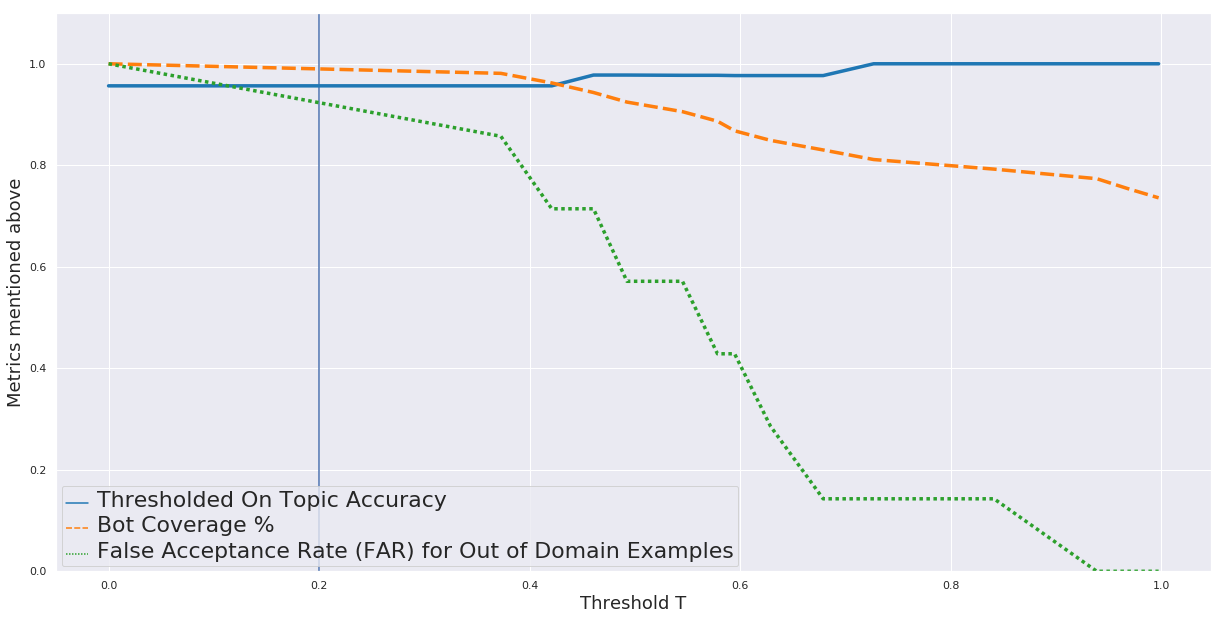

In [23]:
importlib.reload(confidence_analyzer)
analysis_df= confidence_analyzer.analysis(results,None)

## 3.2 Analysis interpretation @ confidence level T <a id='levelT'></a>

If a certain confidence threshold T is selected, then: 
- The on-topic accuracy for test examples which cross the threshold is ***TOA***
- The percentage of total test examples which returns confidences higher than the threshold is measured as ***Bot Coverage %***
- If out of domain examples exist, falsely accept out of domain examples as on topic examples at a rate measured by ***FAR*** (False Acceptance Rate)

In [24]:
analysis_df.index = np.arange(1, len(analysis_df)+1)
display(analysis_df)

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts,False Acceptance Rate (FAR)
1,0.0,95.652174,100.000000,53 / 53,100.000000
2,0.1,95.652174,100.000000,53 / 53,100.000000
3,0.2,95.652174,100.000000,53 / 53,100.000000
4,0.3,95.652174,100.000000,53 / 53,100.000000
5,0.4,95.652174,98.113208,52 / 53,85.714286
6,0.5,97.777778,92.452830,49 / 53,57.142857
7,0.6,97.674419,86.792453,46 / 53,42.857143
8,0.7,97.674419,83.018868,44 / 53,14.285714
9,0.8,100.000000,81.132075,43 / 53,14.285714
10,0.9,100.000000,79.245283,42 / 53,14.285714


### Select the threshold value

By selecting a higher threshold, you can potentially bias your systems so that they are more accurate in terms of determining whether an utterance is on topic or out of domain. The default confidence threshold for Watson Assistance is 0.2.  

**Effect on accuracy**: When you select a higher threshold T, this can result in higher accuracy (TOA) because only examples with confidences greater than the threshold T are included.

**Effect on bot coverage %**: However, when you select a higher threshold T, this can also result in the virtual assistant responding to less examples.

**Deflection to human agent**: In the scenarios where the virtual assistant is setup to hand off to a human agent when it is less confident, having a higher threshold T can:  

- Improve end user experience when interacting with a virtual assistant, as it continues interaction only when its highly confident
- Result in higher costs to the customer as this can result in more deflections to the human agents 

Thus, there is a trade-off and you need to decide on a threshold value on a per customer basis.

### Examine the threshold selection on individual intents
This section allows the examination of thresholds on specific intents.

- Use `INTENT_LIST = []` to get analysis which averages across all intents
- Use `INTENT_LIST = ['intent1', 'intent2']` to examine specific intents and threshold analysis on these intents
- Use `INTENT_LIST = ['ALL_INTENTS']` to examine all intents and threshold analysis for each
- Use `INTENT_LIST = [MOST_FREQUENT_INTENT]` to get analysis on the intent with the most test examples (DEFAULT)

**False Acceptance Rate (FAR) for specific intents**  
When we calculate FAR across all intents (as in previous section) we calculate fraction of out of domain examples falsely considered on topic. When we calculate FAR for specific intents, we calculate the fraction of examples which were falsely predicted to be that specific intent.

In [25]:
importlib.reload(confidence_analyzer)

# Calculate intent with most test examples
for label in list(test_df['intent'].value_counts().index):
    if label != skills_util.OFFTOPIC_LABEL:
        MOST_FREQUENT_INTENT = label 
        break
        
# Specify intents of interest for analysis      
INTENT_LIST = [MOST_FREQUENT_INTENT]  

analysis_df_list = confidence_analyzer.analysis(results, INTENT_LIST)

### Threshold Analysis for Intent: General_Connect_to_Agent

Out of Domain examples fewer than **5** thus             no False Acceptance Rate (FAR) calculated

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts
1,0.0,100.0,100.000000,12 / 12
2,0.1,100.0,100.000000,12 / 12
3,0.2,100.0,100.000000,12 / 12
4,0.3,100.0,100.000000,12 / 12
5,0.4,100.0,100.000000,12 / 12
6,0.5,100.0,100.000000,12 / 12
7,0.6,100.0,91.666667,11 / 12
8,0.7,100.0,91.666667,11 / 12
9,0.8,100.0,83.333333,10 / 12
10,0.9,100.0,83.333333,10 / 12


<a id='part3.2'></a>
## 3.3 Highlight term importance

This intent can be ground-truth or an incorrectly predicted intent. It provides term level insights about which terms the classifier thought were important in relation to that specific intent.

Even if the system predicts an intent correctly, the terms which the intent classifier thought were important may not be as expected by human insight. Human insight might suggest that the intent classifier is focusing on the wrong terms.  

The score of each term in the following highlighted images can be viewed as importance factor of that term for that specific intent. The larger the score, the more important the term.

You can get the highlighted images for either wrongly-predicted utterances or utterances where the classifier returned a low confidence.   

**<font color=red>Note</font>**: You will be charged for calls made from this notebook  based on your WA plan.

### Identified 1 problematic utterances 

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-4
Exiting Thread-1
Exiting Thread-3
Exiting Thread-5
Exiting Thread-2
--- Total time: 0.8515188694000244 seconds ---


1 examples are shown below:

,Characteristic,Value
1,Test Set Index,0
2,Utterance,Where is the closest agent?
3,Actual Intent,General_Connect_to_Agent
4,Predicted Intent,General_Connect_to_Agent
5,Confidence,1


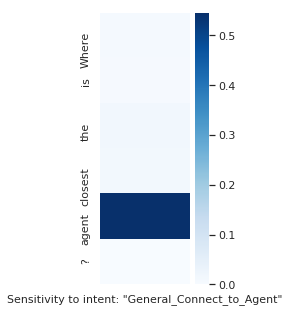

In [26]:
importlib.reload(highlighter)

# Pick an example from section 1 which was misclassified
# Add the example and correct intent for the example
utterance = "Where is the closest agent?"  # input example
intent = "General_Connect_to_Agent"  # input an intent in your workspace which you are interested in.


inference_results = inferencer.inference(conversation=conversation, 
                                    workspace_id=workspace_id, 
                                    test_data=pd.DataFrame({'utterance':[utterance], 
                                                            'intent':[intent]}), 
                                    max_retries = 10, 
                                    max_thread = 1, 
                                    verbose = False)

highlighter.get_highlights_in_batch_multi_thread(conversation, 
                                                 workspace_id,
                                                 inference_results, 
                                                 None,
                                                 1,
                                                 1)

In the section below you analyze your test results and produce highlighting for the top 25 problematic utterances which were either mistakes or had confidences below the threshold that was set.    

**<font color=red>Note</font>**: You will be charged for calls made from this notebook  based on your WA plan.

### Identified 9 problematic utterances 

Starting Thread-1
Starting Thread-2
Starting Thread-3
Starting Thread-4
Starting Thread-5
Exiting Thread-4
Exiting Thread-5
Exiting Thread-1
Exiting Thread-3
Exiting Thread-2
--- Total time: 8.803994178771973 seconds ---


25 examples are shown below:

,Characteristic,Value
1,Test Set Index,52
2,Utterance,What is a way to change my account address?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.93823


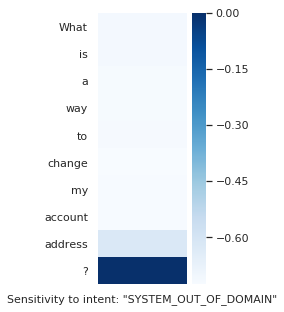

,Characteristic,Value
1,Test Set Index,43
2,Utterance,see you tomorrow
3,Actual Intent,Goodbye
4,Predicted Intent,General_Greetings
5,Confidence,0.709415


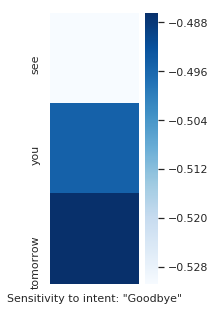

,Characteristic,Value
1,Test Set Index,44
2,Utterance,I dont think I want to do that
3,Actual Intent,Cancel
4,Predicted Intent,General_Connect_to_Agent
5,Confidence,0.449863


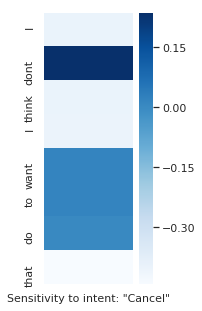

,Characteristic,Value
1,Test Set Index,49
2,Utterance,Where did Betty buy her butter?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Location
5,Confidence,0.648318


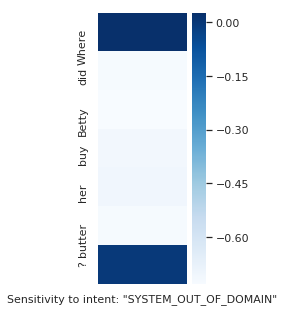

,Characteristic,Value
1,Test Set Index,50
2,Utterance,Can you help me change my account password?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Help
5,Confidence,0.609402


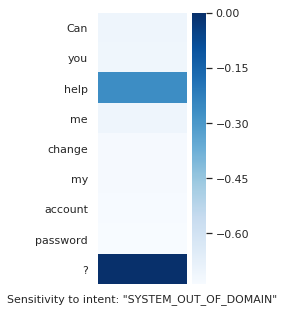

,Characteristic,Value
1,Test Set Index,51
2,Utterance,How many engineers does it take to change a lightbulb?
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,General_Connect_to_Agent
5,Confidence,0.576895


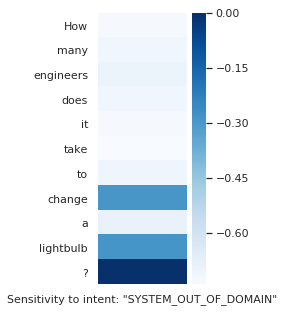

,Characteristic,Value
1,Test Set Index,46
2,Utterance,Can you tell me a good joke
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,General_Greetings
5,Confidence,0.471448


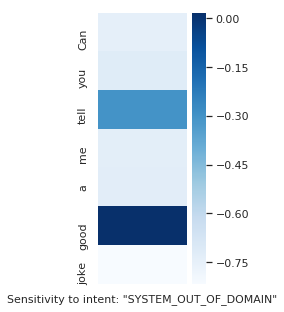

,Characteristic,Value
1,Test Set Index,47
2,Utterance,What is your IQ
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Hours
5,Confidence,0.392185


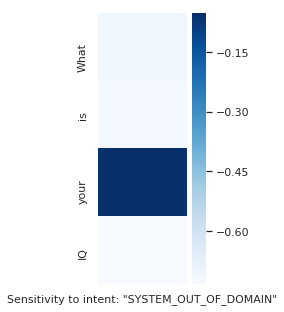

,Characteristic,Value
1,Test Set Index,48
2,Utterance,"Luke, I am your father"
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Customer_Care_Store_Hours
5,Confidence,0.353161


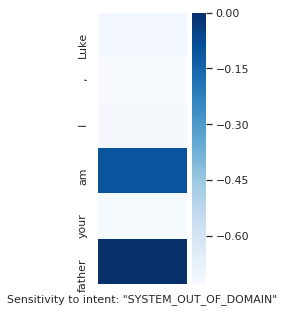

In [27]:
importlib.reload(highlighter)

# The output folder for generated images
# Note modify this if you want the generated images to be stored in a different directory

highlighting_output_folder = './highlighting_images/'
if not os.path.exists(highlighting_output_folder):
    os.mkdir(highlighting_output_folder)

# The threshold the prediction needs to achieve below which  
# it will be considered as `out of domain` or `offtopic` utterances. 
threshold = 0.2

# Maximum number of test set examples whose highlighting analysis will be conducted
K=25
highlighter.get_highlights_in_batch_multi_thread(conversation, 
                                                 workspace_id,full_results, 
                                                 highlighting_output_folder,
                                                 threshold,
                                                 K)

<a id='part3.3'></a>
## 3.4 Analyze abnormal confidence levels
Every test utterance is classified as a specific intent with a specific confidence by the Watson Assistant intent classifier. It is expected that model would be confident when it correctly predicts examples and not highly confident when it incorrectly predicts examples. 

But this is not always true. This can be because there are anomalies in the design. Examples that are predicted correctly with low confidence and the examples that are predicted incorrectly with high confidence are cases which need to be reviewed.

In [28]:
importlib.reload(confidence_analyzer)
correct_thresh, wrong_thresh = 0.3, 0.7
correct_with_low_conf_list, incorrect_with_high_conf_list = confidence_analyzer.abnormal_conf(
    full_results, correct_thresh, wrong_thresh)

In [29]:
if len(correct_with_low_conf_list) > 0:
    display(Markdown("#### Examples correctedly predicted with low confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(correct_with_low_conf_list.to_html(index=False)))

In [30]:
if len(incorrect_with_high_conf_list) > 0:
    display(Markdown("#### Examples incorrectedly predicted with high confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(incorrect_with_high_conf_list.to_html(index=False)))

#### Examples incorrectedly predicted with high confidence

correct_intent,utterance,top1_prediction,top2_prediction,top3_prediction
Goodbye,see you tomorrow,General_Greetings (0.709),Customer_Care_Appointments (0.3),Goodbye (0.271)


### Actions to take when you have examples of abnormal confidence

If there are examples which are incorrectly classified with high confidence for specific intents, it may indicate an issue in the design of those specific intents because the user examples provided for that intent may be overlapping with the design of other intents.

If intent A seems to always get misclassified as intent B with high confidence or gets correctly predicted with low confidence, consider using intent conflict detection. For more information, refer to the <a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts" target="_blank" rel="noopener no referrer">Conflict Resolution Documentation</a>.

Also consider whether those two intents need to be two separate intents or whether they need to be merged. If they can't be merged, then consider adding more user examples which distinguish intent A specifically from intent B.

<a id='part3.4'></a>
## 3.5 Perform an analysis using correlated entities per intent

Perform a chi square significance test for entities such as we or you for unigrams and bigrams in the previous section. For each utterance in the training data, this analysis will call the message API for entity detection on each utterance and find the most correlated entities for each intent.

**<font color=red>Note</font>**: You will be charged for calls made from this notebook  based on your Watson Assistant plan. 

In [31]:
importlib.reload(entity_analyzer)
importlib.reload(inferencer)
if entities_list:
    THREAD_NUM = 5# we allow a maximum of 5 threads for faster inference
    train_full_results = inferencer.inference(conversation,
                                              workspace_id,
                                              workspace_pd,
                                              max_retries=10, 
                                              max_thread=THREAD_NUM,
                                              verbose=False)
    entity_label_correlation_df = entity_analyzer.entity_label_correlation_analysis(
        train_full_results, entities_list)
    with pd.option_context('display.max_colwidth', 200):
        entity_label_correlation_df.index = np.arange(1, len(entity_label_correlation_df) + 1)
        display(entity_label_correlation_df)
else:
    display(Markdown("### Target workspace has no entities."))

Starting Thread-1Starting Thread-2
Starting Thread-3

Starting Thread-4
Starting Thread-5
Exiting Thread-2
Exiting Thread-4
Exiting Thread-5
Exiting Thread-3
Exiting Thread-1
--- Total time: 26.995890140533447 seconds ---


,Intent,Correlated Entities
1,General_Connect_to_Agent,"sys-date, reply"
2,Customer_Care_Store_Hours,"holiday, reply"
3,Customer_Care_Appointments,sys-number


<a id='part4'></a>
## Part 4: Summary
Congratulations! You have successfully completed the dialog skill analysis training. <br>
This notebook is designed to improve our dialog skill analysis in an iterative fashion. Use it to tackle one aspect of your dialog skill at a time and start over for another aspect later for continuous improvement.

##  Glossary

**True Positives (TP):** True Positive measures the number of correctly predicted positive values meaning that predicted class is the same as the actual class which is the target intent.

**True Negatives (TN):** True Negative measures the number of correctly predicted negative values meaning that the predicted class is the same as the actual class which is not the target intent.

**False Positives (FP):** False Positive measures the number of incorrectly predicted positive values meaning that the predicted class is the target intent but the actual class is not the target intent.  

**False Negatives (FN):** False Negatives measures the number of incorrectly predicted negative values meaning that the predicted class is not the target intent but the actual class is the target intent. 

**Accuracy:** Accuracy measures the ratio of corrected predicted user examples out of all user examples.   
Accuracy = (TP + TN) / (TP + TN + FP + FN)  

**Precision:** Precision measures the ratio of correctly predicted positive observations out of total predicted positive observations.   
Precision = TP / (TP + FP)  

**Recall:** Recall measures the ratio of correctly predicted positive observations out of all observations of the target intent.  
Recall = TP / (TP + FN)

**F1 Score:** F1 Score is the harmonic average of Precision and Recall.  
F1 = 2 \* (Precision \* Recall)/ (Precision + Recall)

For more information related to Watson Assistant, refer to the <a href="https://cloud.ibm.com/docs/services/assistant" target="_blank" rel="noopener no referrer">Watson Assistant Documentation</a>.

###  Authors

**Haode Qi** is a data scientist at IBM Watson. He conducts research with NLP technologies and delivers Machine Learning Algorithm into IBM Watson's market leading conversational AI service. He is involved in several IBM open-source projects like the Auto-AI framework Lale and works with a dozen of clients to improve their AI chatbot.

**Navneet Rao** is an engineering lead at IBM Watson. He believes in building unique AI-powered experiences which augment human capabilities. He currently works on AI innovation & research for IBM's award-winning conversational computing platform, the IBM Watson Assistant. 

**Ming Tan**, PhD, is a data scientist at IBM Watson. He is mainly working on prototyping and productization of various algorithmic features related to Watson Assistant service. He demonstrates a broad research interest on deep learning approaches for conversational service and related NLP tasks, such as low-resource intent classification, out-of-domain detection, multi-user chat channels, passage-level semantic matching and entity detection. Multiple research works have been published on top-tier NLP conferences.

**Yang Yu**, PhD, is a data scientist at IBM Watson. His research focusses mainly include language understanding, question answering, deep learning and representations learning methods for different NLP tasks. At IBM, he achieved awards on several internal machine learning competitions with global researchers. A few novel machine learning solutions he designed and developed solved some critical question answering and human-computer dialog problem in general for several popular Watson Services on the market.

<hr>
Copyright &copy; IBM Corp. 2019. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>